In [6]:
import pandas as pd
import time 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
from sklearn.cluster import DBSCAN
from xgboost import XGBClassifier, DMatrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek
import re

import random
random.seed(804)

In [7]:
train = pd.read_csv('train(분포 무작위 추출&2426열제거).csv', encoding='cp949')
test = pd.read_csv('test(분포 무작위 추출&2426열제거).csv', encoding='cp949')

In [8]:
# 변수 형태별 리스트
cat_list = [a for a in train.columns if a.endswith('cat')]
bin_list = [a for a in train.columns if a.endswith('bin')]
int_list = [a for a in train.columns if a not in cat_list and a not in bin_list]

In [9]:
# 범주형 변환 
train[cat_list] = train[cat_list].astype('category')
test[cat_list] = test[cat_list].astype('category')

### one-hot encoding
- LabelEncoder: 디코딩하기 쉬움, 문자열 값들이 일괄적인 숫자형으로 변환되면서 숫자의 크고 작은 특성이 반영된다는 단점
- One Hot Encoder: 피처 값의 종류에 따라 컬럼을 추가해 해당하는 컬럼에만 1을 표시하고 나머지 컬럼에는 0을 채워줌으로써 이러한 단점 보완

In [10]:
'''# 범주형 더미변수 변환 
train_dum = pd.get_dummies(train)
test_dum = pd.get_dummies(test)

print("원본 특성 :\n", list(train_dum.columns))

# LGBM 모델의 non-ascii characters 오류 방지 위해 컬럼 이름 변경
train_dum = train_dum.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_dum = test_dum.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))'''

'# 범주형 더미변수 변환 \ntrain_dum = pd.get_dummies(train)\ntest_dum = pd.get_dummies(test)\n\nprint("원본 특성 :\n", list(train_dum.columns))\n\n# LGBM 모델의 non-ascii characters 오류 방지 위해 컬럼 이름 변경\ntrain_dum = train_dum.rename(columns = lambda x:re.sub(\'[^A-Za-z0-9_]+\', \'\', x))\ntest_dum = test_dum.rename(columns = lambda x:re.sub(\'[^A-Za-z0-9_]+\', \'\', x))'

<AxesSubplot:>

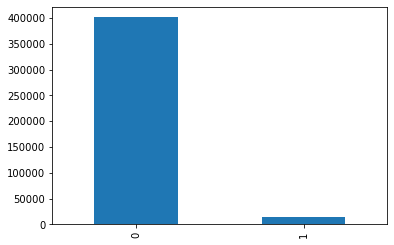

In [11]:
train['target'].value_counts().plot(kind="bar") #클래스 불균형으로 과적합 가능: under나 over sampling 필요

In [12]:
X = train.iloc[:,2:]
y = train['target']

In [13]:
#랜덤 오버 샘플링으로 클래스 불균형 개선 
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)

print("sampling 적용 전 학습용 피처/레이블 데이터 세트 : ", X.shape, y.shape)
print('sampling 적용 후 학습용 피처/레이블 데이터 세트 :', X_over.shape, y_over.shape)

sampling 적용 전 학습용 피처/레이블 데이터 세트 :  (416648, 55) (416648,)
sampling 적용 후 학습용 피처/레이블 데이터 세트 : (802838, 55) (802838,)


<AxesSubplot:>

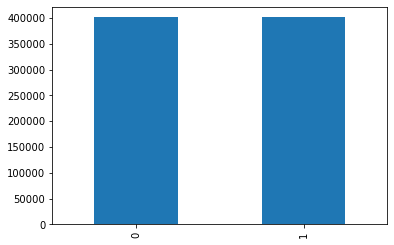

In [14]:
#샘플링 적용 후 target 비율 
y_over.value_counts().plot(kind="bar") 

In [15]:
'''from bayes_opt import BayesianOptimization
from lightgbm import LGBMClassifier

LGBM_parameter_bounds ={
    'num_leaves':(24, 45),
    'min_child_weight':(5, 50),
    'bagging_freq':(0.5,2),
    'max_depth':(5, 8.99),
    'learning_rate':(0.5,0.8),
    'n_estimators':(100,800)
                 
}

def lgbm_bo(num_leaves, min_child_weight, bagging_freq, max_depth, learning_rate,n_estimators):
    
    LGBM_parameter_bounds = {
        'num_leaves':int(round(num_leaves)),
        'min_child_weight': int(round(min_child_weight)),
        'bagging_freq':int(round(bagging_freq)),
        'max_depth': int(round(max_depth)),
        'learning_rate': int(round(learning_rate)),
         'n_estimators': int(round(n_estimators))
        
    }
    lgbm = LGBMClassifier(** LGBM_parameter_bounds,n_jobs=-1,is_unbalanced = True, random_state=804, 
                          categorical_feature = 'auto', boosting_type = 'gbdt')
    
    x_train, x_val, y_train_split, y_val_split = train_test_split(X_train, y_train,
                                                                  test_size=0.2, random_state=804)
    
    lgbm.fit(x_train, y_train_split)
    
    f1 = f1_score(y_val_split, lgbm.predict(x_val),average='macro')
    return f1

optimizer = BayesianOptimization(f=lgbm_bo,
                                pbounds=LGBM_parameter_bounds,
                                random_state=804) 

optimizer.maximize(init_points = 5, n_iter = 7)'''

"from bayes_opt import BayesianOptimization\nfrom lightgbm import LGBMClassifier\n\nLGBM_parameter_bounds ={\n    'num_leaves':(24, 45),\n    'min_child_weight':(5, 50),\n    'bagging_freq':(0.5,2),\n    'max_depth':(5, 8.99),\n    'learning_rate':(0.5,0.8),\n    'n_estimators':(100,800)\n                 \n}\n\ndef lgbm_bo(num_leaves, min_child_weight, bagging_freq, max_depth, learning_rate,n_estimators):\n    \n    LGBM_parameter_bounds = {\n        'num_leaves':int(round(num_leaves)),\n        'min_child_weight': int(round(min_child_weight)),\n        'bagging_freq':int(round(bagging_freq)),\n        'max_depth': int(round(max_depth)),\n        'learning_rate': int(round(learning_rate)),\n         'n_estimators': int(round(n_estimators))\n        \n    }\n    lgbm = LGBMClassifier(** LGBM_parameter_bounds,n_jobs=-1,is_unbalanced = True, random_state=804, \n                          categorical_feature = 'auto', boosting_type = 'gbdt')\n    \n    x_train, x_val, y_train_split, y_val_

In [16]:
'''from sklearn.model_selection import GridSearchCV
from itertools import product

lgbm_clf = LGBMClassifier(random_state=804)
lgbm_clf.fit(train, target_train)

parameters = {
    'n_estimators': [600,1000],
    'learning_rate':[0.02],
    'num_leaves' : [12,16,20],
    'min_child_samples' : [500],
    'max_depth':[2,4,6]
    
}

grid_cv = GridSearchCV(lgbm_clf, param_grid = parameters, scoring ='f1', cv=3, verbose=1)
grid_cv.fit(train, target_train)

cv_results_df = pd.DataFrame(gird_cv.cv_results)
cv_results_df
'''

"from sklearn.model_selection import GridSearchCV\nfrom itertools import product\n\nlgbm_clf = LGBMClassifier(random_state=804)\nlgbm_clf.fit(train, target_train)\n\nparameters = {\n    'n_estimators': [600,1000],\n    'learning_rate':[0.02],\n    'num_leaves' : [12,16,20],\n    'min_child_samples' : [500],\n    'max_depth':[2,4,6]\n    \n}\n\ngrid_cv = GridSearchCV(lgbm_clf, param_grid = parameters, scoring ='f1', cv=3, verbose=1)\ngrid_cv.fit(train, target_train)\n\ncv_results_df = pd.DataFrame(gird_cv.cv_results)\ncv_results_df\n"

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=804)

In [18]:
def evalutation(y_test, prediction):
    report = classification_report(y_test, prediction)
    acc = accuracy_score(y_test, prediction)
    pre = precision_score(y_test, prediction)
    recall = recall_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    
    print('report')
    print(report)
    print('정확도:{}, 정밀도:{}, 재현율:{}, f1 score:{}'.format(acc, pre, recall, f1))

In [19]:
numeric_variable = ["V1", "V3", "V5", "V14", "V15", "V19", "V20", "V21", "V34", "V35", "V36", "V37", "V38", "V39", "V40", "V41", "V42", 
                   "V43", "V44", "V45", "V46", "V47", "V48", "V49", "V50", "V51"]

In [20]:
from sklearn.preprocessing import StandardScaler

# 객체 생성
scaler = StandardScaler()   

# 훈련데이터의 분포 저장
scaler.fit(X_train[numeric_variable])

# 훈련 데이터 스케일링
scaler_scaled = scaler.transform(X_train[numeric_variable])

In [21]:
scaler_scaled = pd.DataFrame(scaler_scaled, columns = numeric_variable)

In [22]:
X_train[numeric_variable] = scaler_scaled

In [23]:
from sklearn.preprocessing import StandardScaler

# 객체 생성
scaler = StandardScaler()   

# 훈련데이터의 분포 저장
scaler.fit(X_test[numeric_variable])

# 훈련 데이터 스케일링
scaler_scaled = scaler.transform(X_test[numeric_variable])

In [24]:
scaler_scaled = pd.DataFrame(scaler_scaled, columns = numeric_variable)

In [25]:
X_test[numeric_variable] = scaler_scaled

In [26]:
# LGBM modeling-변수 그대로 사용
start1 = time.time()
model = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1, random_state=804, is_unbalance=True)
evals = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss', eval_set=evals, verbose=True)
end1 = time.time()
start2 = time.time()
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:1]
end2 = time.time()

evalutation(y_test, pred) # f1 score: 0.95

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column

[1]	valid_0's binary_logloss: 0.673432
[2]	valid_0's binary_logloss: 0.662585
[3]	valid_0's binary_logloss: 0.658449
[4]	valid_0's binary_logloss: 0.659592
[5]	valid_0's binary_logloss: 0.664939
[6]	valid_0's binary_logloss: 0.673749
[7]	valid_0's binary_logloss: 0.68539
[8]	valid_0's binary_logloss: 0.699429
[9]	valid_0's binary_logloss: 0.715483
[10]	valid_0's binary_logloss: 0.733272
[11]	valid_0's binary_logloss: 0.752581
[12]	valid_0's binary_logloss: 0.773152
[13]	valid_0's binary_logloss: 0.794871
[14]	valid_0's binary_logloss: 0.817556
[15]	valid_0's binary_logloss: 0.841097
[16]	valid_0's binary_logloss: 0.865416
[17]	valid_0's binary_logloss: 0.890415
[18]	valid_0's binary_logloss: 0.915979
[19]	valid_0's binary_logloss: 0.942084
[20]	valid_0's binary_logloss: 0.968632
[21]	valid_0's binary_logloss: 0.99562
[22]	valid_0's binary_logloss: 1.02297
[23]	valid_0's binary_logloss: 1.05065
[24]	valid_0's binary_logloss: 1.07864
[25]	valid_0's binary_logloss: 1.1069
[26]	valid_0's b

In [27]:
print('train 데이터 학습 시간: ',end1 - start1)
print('test 데이터 예측 시간:', end2 - start2)

train 데이터 학습 시간:  4.1264283657073975
test 데이터 예측 시간: 0.27719759941101074


In [28]:
#submission 파일 생성 
id_test = test['id'].values
testset = test.drop(['id'],axis = 1)

# 객체 생성
scaler = StandardScaler()   

# 훈련데이터의 분포 저장
scaler.fit(testset[numeric_variable])

# 훈련 데이터 스케일링
scaler_scaled = scaler.transform(testset[numeric_variable])

In [29]:
scaler_scaled = pd.DataFrame(scaler_scaled, columns = numeric_variable)

In [30]:
testset[numeric_variable] = scaler_scaled

In [31]:
prediction_final = model.predict(testset)

submission= pd.DataFrame()
submission['id'] = id_test
submission['target'] = prediction_final

submission.to_csv('submission_final.csv', encoding = 'cp949',index = False)